In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prince import MCA

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
setattr(pd, "Int64Index", pd.Index)
setattr(pd, "Float64Index", pd.Index)

# EDA

In [2]:
SEED = 33
TARGET = 'price'

df = pd.read_csv('Automobile_data.csv')

# "?" is representing missing values in data hence replace with NaN
df = df.replace('?', np.nan)

print(df.shape)
df = df.dropna(subset=[TARGET])
print(df.shape)

df[TARGET] = df[TARGET].astype(int)

(205, 26)
(201, 26)


In [3]:
# Missing check
df.isnull().sum()[df.isnull().sum() > 0]

normalized-losses    37
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
dtype: int64

##### Fill Missing Strategy

- Group-Based Filling: Missing values are filled using the mean of the respective column within each group (e.g., make) if sufficient data is available.
- Price-Based Filling: For groups with entirely missing values in a column, the mean of rows with similar prices is used to estimate missing values.
- Global Filling: For columns like horsepower and peak-rpm, missing values are filled with the overall mean. For categorical columns like num-of-doors, the most frequent value is used.

In [4]:
def group_based_filler(grp, cols_to_fill):
    """
    Fills missing values based on make (brand)
    """
    grp[cols_to_fill] = grp[cols_to_fill].astype(float)
    grp_mean = grp[cols_to_fill].dropna().mean()
    grp[cols_to_fill] = grp[cols_to_fill].fillna(grp_mean)
    return grp

def price_based_filler(grp, cols_to_fill):
    """
    Fills missing values based on rows that have similiar price
    """
    brand = grp['make'].values[0]
    grp[cols_to_fill] = grp[cols_to_fill].astype(float)
    brand_price_mean = df[df['make'] == brand]['price'].mean()
    calculated_losses_based_nearest_prices = int(df.loc[(df[df[cols_to_fill].isnull() == False][TARGET] - brand_price_mean).abs().sort_values().head(3).index.tolist()][cols_to_fill].astype(float).mean())
    grp[cols_to_fill] = grp[cols_to_fill].fillna(calculated_losses_based_nearest_prices)
    return grp


df = df.groupby('make').apply(lambda x: group_based_filler(x, 'normalized-losses') if not x['normalized-losses'].isnull().all() else price_based_filler(x, 'normalized-losses')).reset_index(drop=True)
df = df.groupby('make').apply(group_based_filler, 'bore').reset_index(drop=True)
df = df.groupby('make').apply(group_based_filler, 'stroke').reset_index(drop=True)

hp_mean = df[(df['horsepower'].isnull() == False)]['horsepower'].astype(float).mean()
df['horsepower'] = df['horsepower'].astype('float').fillna(hp_mean)

rpm_mean = df[(df['peak-rpm'].isnull() == False)]['peak-rpm'].astype(float).mean()
df['peak-rpm'] = df['peak-rpm'].astype('float').fillna(rpm_mean)

num_of_door_most_freq = df['num-of-doors'].mode().iloc[0]
df['num-of-doors'] = df['num-of-doors'].fillna(num_of_door_most_freq)

In [5]:
df.groupby(['make']).describe()

symboling                                                 \
                  count      mean       std  min   25%  50%   75%  max   
make                                                                     
alfa-romero         3.0  2.333333  1.154701  1.0  2.00  3.0  3.00  3.0   
audi                6.0  1.500000  0.547723  1.0  1.00  1.5  2.00  2.0   
bmw                 8.0  0.375000  0.744024  0.0  0.00  0.0  0.25  2.0   
chevrolet           3.0  1.000000  1.000000  0.0  0.50  1.0  1.50  2.0   
dodge               9.0  1.000000  1.000000 -1.0  1.00  1.0  1.00  3.0   
honda              13.0  0.615385  0.767948  0.0  0.00  0.0  1.00  2.0   
isuzu               2.0  1.000000  1.414214  0.0  0.50  1.0  1.50  2.0   
jaguar              3.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0   
mazda              17.0  1.117647  1.166316  0.0  0.00  1.0  1.00  3.0   
mercedes-benz       8.0  0.000000  1.414214 -1.0 -1.00 -0.5  0.25  3.0   
mercury             1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0   
mitsubishi         13.0  1.846154  1.214232 -1.0  1.00  2.0  3.00  3.0   
nissan             18.0  1.000000  0.907485  0.0  0.25  1.0  1.00  3.0   
peugot             11.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0   
plymouth            7.0  1.000000  1.154701 -1.0  1.00  1.0  1.00  3.0   
porsche             4.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0   
renault             2.0  1.000000  1.414214  0.0  0.50  1.0  1.50  2.0   
saab                6.0  2.500000  0.547723  2.0  2.00  2.5  3.00  3.0   
subaru             12.0  0.500000  0.904534  0.0  0.00  0.0  0.50  2.0   
toyota             32.0  0.562500  1.216486 -1.0  0.00  0.0  1.25  3.0   
volkswagen         12.0  1.666667  1.073087  0.0  1.50  2.0  2.00  3.0   
volvo              11.0 -1.272727  0.467099 -2.0 -1.50 -1.0 -1.00 -1.0   

              normalized-losses                                                \
                          count        mean        std    min     25%     50%   
make                                                                            
alfa-romero                 3.0  138.000000   0.000000  138.0  138.00  138.00   
audi                        6.0  161.000000   2.683282  158.0  158.75  161.00   
bmw                         8.0  190.000000   1.511858  188.0  189.50  190.00   
chevrolet                   3.0  100.000000  20.074860   81.0   89.50   98.00   
dodge                       9.0  133.444444  16.756425  110.0  118.00  145.00   
honda                      13.0  103.000000  18.266545   78.0   85.00  101.00   
isuzu                       2.0   83.000000   0.000000   83.0   83.00   83.00   
jaguar                      3.0  145.000000   0.000000  145.0  145.00  145.00   
mazda                      17.0  123.933333  16.723736  104.0  113.00  118.00   
mercedes-benz               8.0  102.800000  16.565023   93.0   93.00   97.90   
mercury                     1.0  154.000000        NaN  154.0  154.00  154.00   
mitsubishi                 13.0  146.200000  14.146849  125.0  137.00  146.20   
nissan                     18.0  135.166667  36.851451  103.0  108.00  128.00   
peugot                     11.0  161.000000   0.000000  161.0  161.00  161.00   
plymouth                    7.0  129.000000  29.154759   74.0  119.00  129.00   
porsche                     4.0  186.000000   0.000000  186.0  186.00  186.00   
renault                     2.0  136.000000   0.000000  136.0  136.00  136.00   
saab                        6.0  127.000000  25.195238  104.0  104.00  127.00   
subaru                     12.0   92.250000   8.833047   83.0   84.50   89.00   
toyota                     32.0  110.290323  40.058178   65.0   85.50   91.00   
volkswagen                 12.0  121.250000  44.590562   94.0   94.00  121.25   
volvo                      11.0   91.454545  11.733402   74.0   84.50   95.00   

                               wheel-base                                   \
                    75%    max      count        mean      

### Regplot

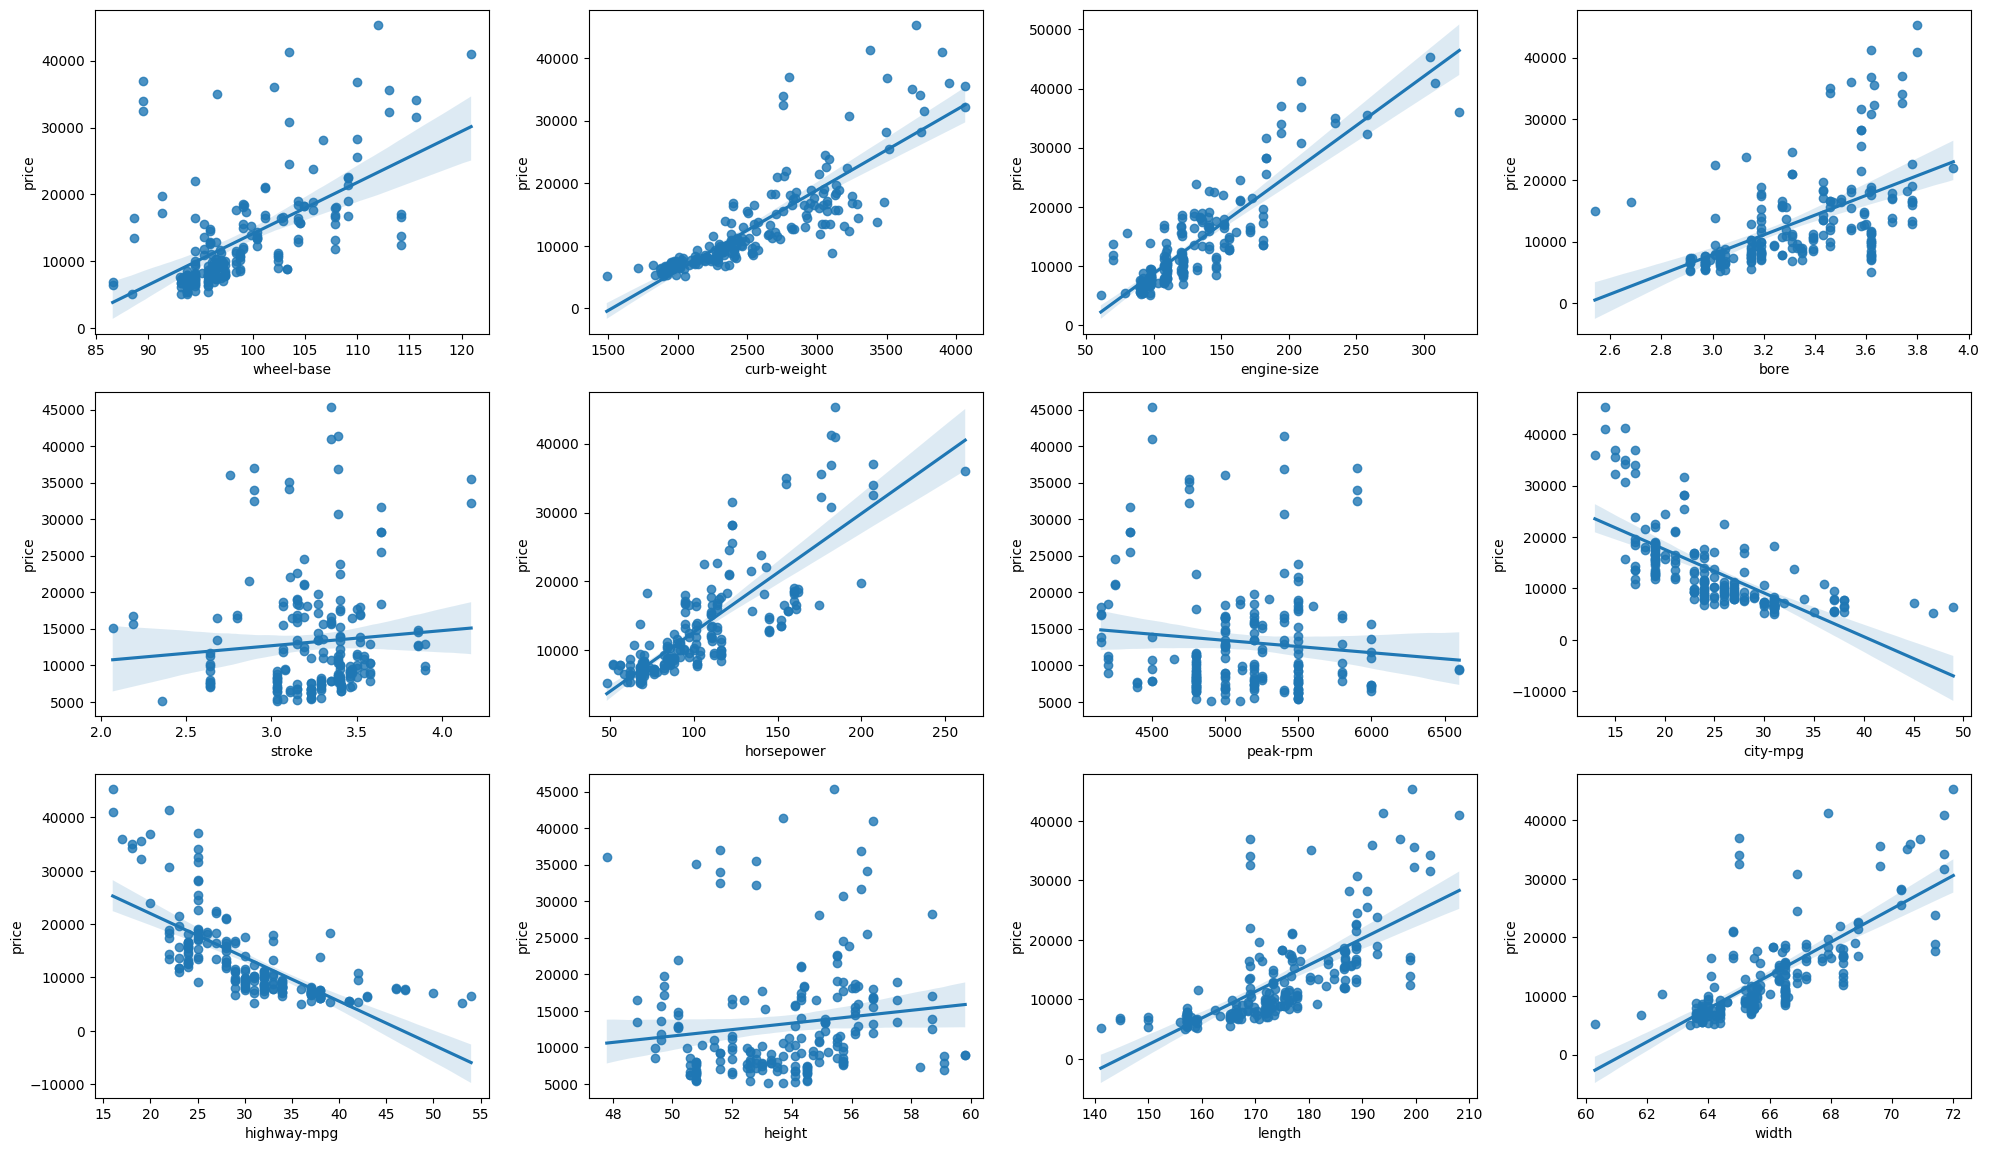

In [6]:
num_cols = ['wheel-base', 'curb-weight', 'engine-size', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'height', 'length', 'width']

nrows = len(num_cols) // 3
ncols = len(num_cols) // 3

plt.figure(figsize=(20,15))
for i in range(len(num_cols)):
    col = num_cols[i]
    plt.subplot(nrows, ncols, i+1)
    sns.regplot(data=df, x=col, y=TARGET)

plt.savefig('plot/num_cols_regplot.png', facecolor='white', transparent=False)
plt.tight_layout()
plt.show()

### Insights:
##### Strong Predictors of Price:
- Engine-size, horsepower, curb-weight (strong positive relationships).
- Highway-mpg (strong negative relationship).

##### Weak Predictors of Price:
- Stroke, peak-rpm (weak correlations).

##### Outliers:
- Some plots show outliers that might distort the regression relationships. These should be investigated further to ensure model robustness.

### Boxplot Analysis

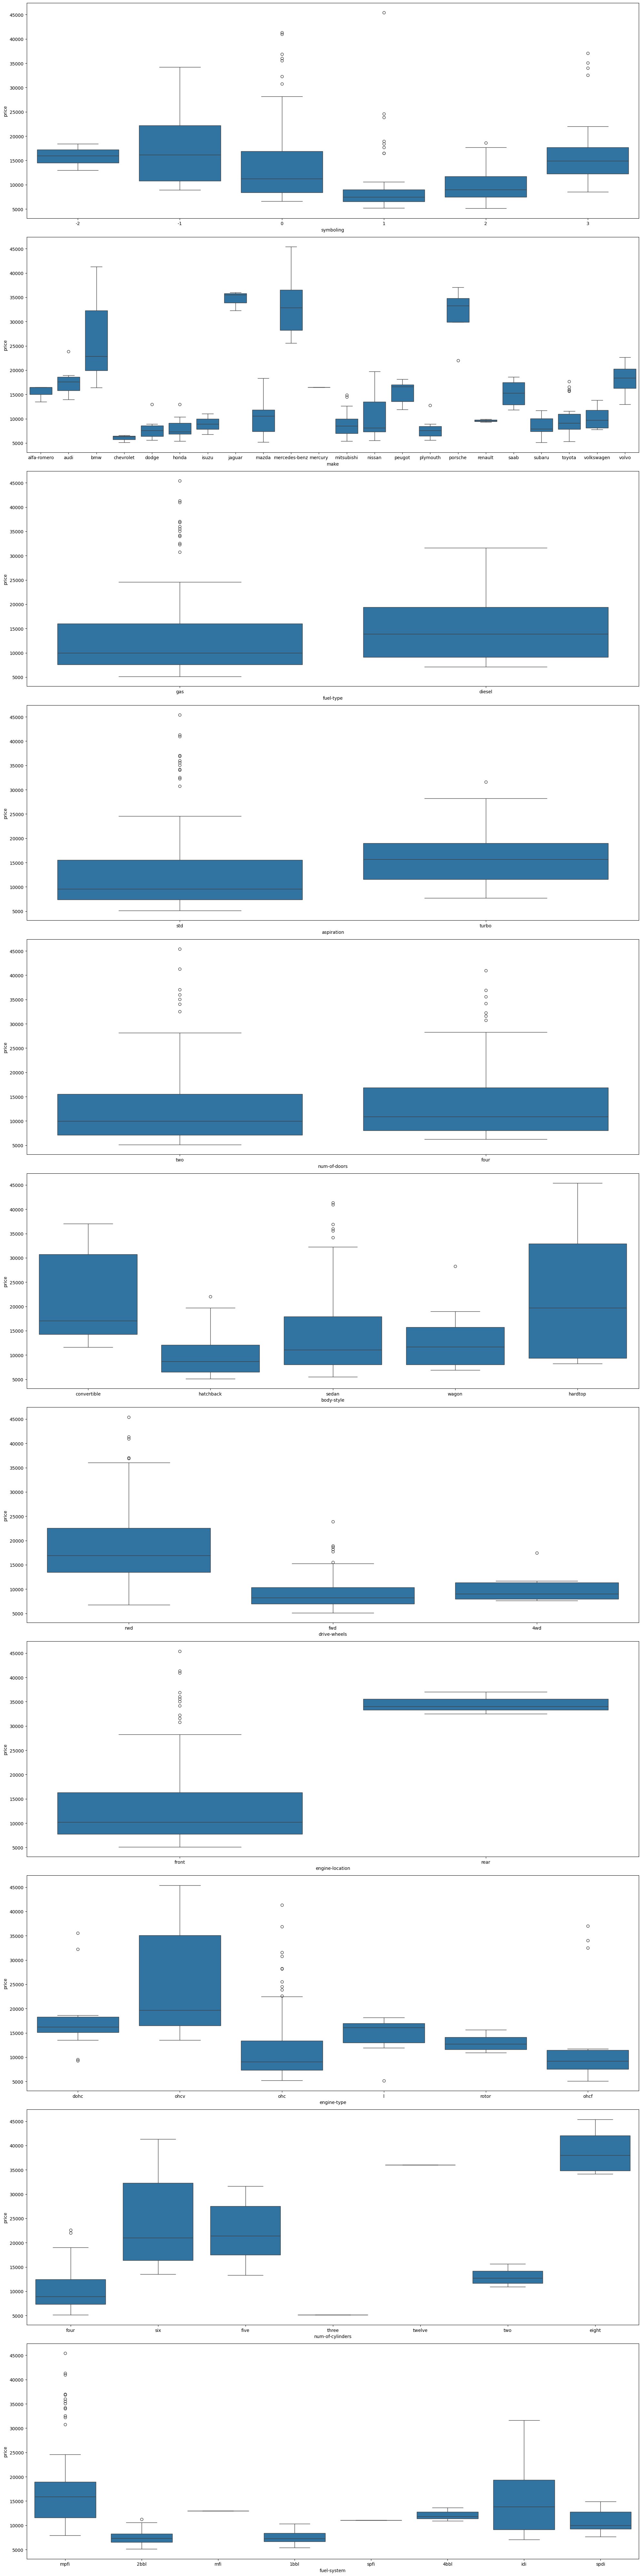

In [7]:
cat_cols = ['symboling'] + df.select_dtypes('object').columns.tolist()

f, axes = plt.subplots(len(cat_cols), figsize = (20,80))
for i in range(len(cat_cols)):
    col = cat_cols[i]
    sns.boxplot(x=col, y=TARGET, data=df, ax=axes[i])

plt.savefig('plot/cat_cols_boxplots.png', facecolor='white', transparent=False)
plt.tight_layout()
plt.show()

### Insights:
- Luxury Segments: Categories like rear engine, rwd, convertible, and manufacturers like bmw, mercedes-benz, and porsche dominate the high-price range.
- Economy Segments: Features like fwd, gas, and brands like toyota and honda are associated with lower prices.
- Performance Indicators: Higher number-of-cylinders, turbo aspiration, and certain engine types are strongly tied to high prices.

In [8]:
# df.to_excel('clean_data.xlsx', index=False)

## Correlations

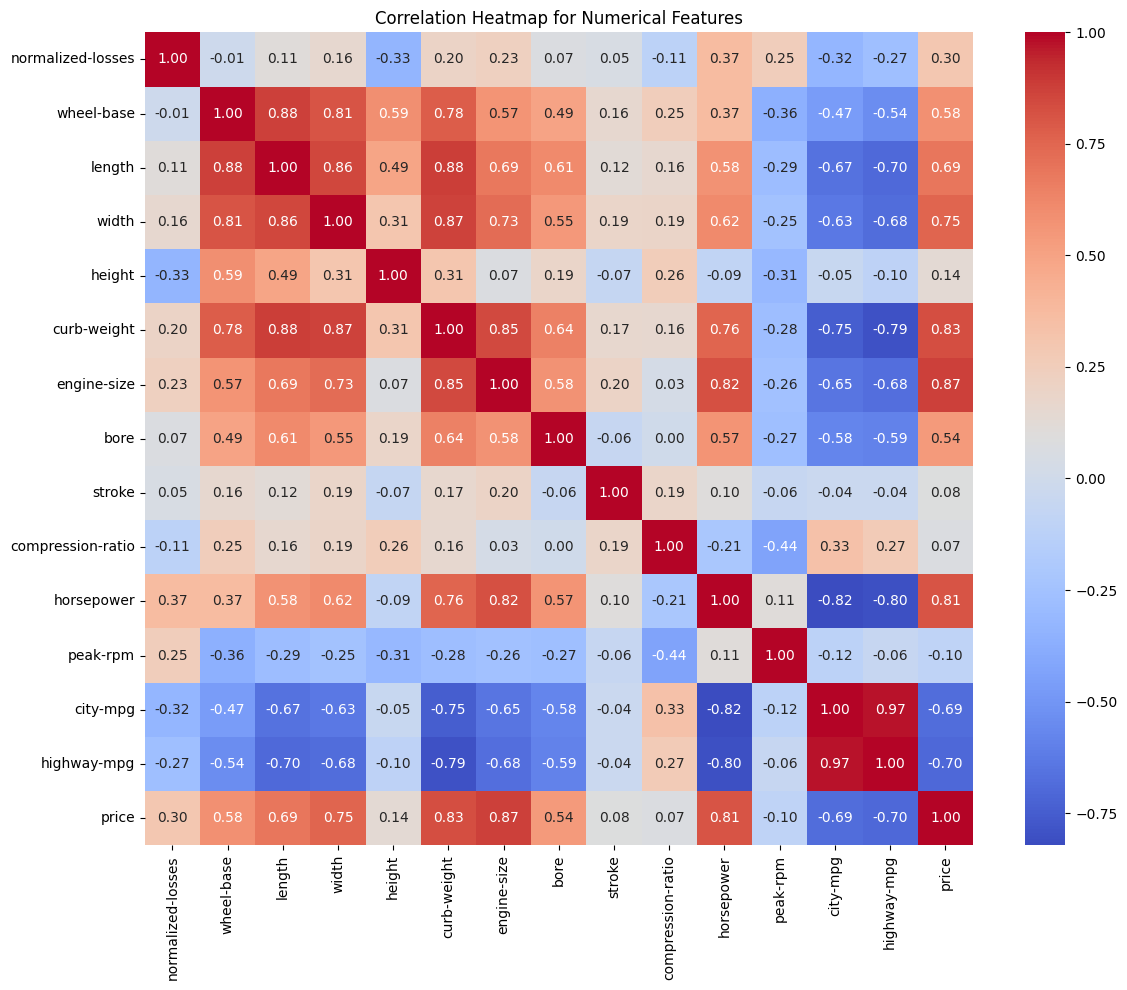

In [10]:
num_cols = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
num_cols = [i for i in num_cols if i != 'symboling']


corr = df[num_cols].corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for Numerical Features')

plt.savefig('plot/corr.png', facecolor='white', transparent=False)
plt.tight_layout()
plt.show()

### Insights:
- Important Predictors:
engine-size, horsepower, curb-weight, width, and length should be considered key features for predicting price.
Fuel efficiency metrics (city-mpg and highway-mpg) are also critical due to their strong negative correlation with price.
- Less Relevant Features:
normalized-losses, stroke, and compression-ratio have weak correlations with price and may contribute less to the model.
- Feature Engineering:
Derive a feature like power-to-weight ratio (horsepower / curb-weight) to capture combined effects of performance and weight.
Cluster vehicles into categories (e.g., economy, mid-range, luxury) and analyze price drivers within each segment.
- Multicollinearity:
High correlations among predictors like engine-size, horsepower, and curb-weight suggest potential multicollinearity. Consider techniques like Ridge or Lasso regression to handle this.

# MCA

In [10]:
for i in [2, 3, 4, 5]:
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    df_cat = df[cat_cols]
    mca = MCA(n_components=i, random_state=SEED)
    fitted_mca = mca.fit(df_cat)
    transformed_mca = fitted_mca.transform(df_cat)
    mca_df = pd.DataFrame(transformed_mca.values, columns=[f"Dimension {i+1}" for i in range(i)])
    mca_df['price'] = df['price']

    display(fitted_mca.eigenvalues_summary)

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.352,7.18%,7.18%
1,0.337,6.89%,14.07%


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.352,7.18%,7.18%
1,0.337,6.89%,14.07%
2,0.311,6.35%,20.42%


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.352,7.18%,7.18%
1,0.337,6.89%,14.07%
2,0.311,6.35%,20.42%
3,0.254,5.19%,25.61%


,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.352,7.18%,7.18%
1,0.337,6.89%,14.07%
2,0.311,6.35%,20.42%
3,0.254,5.19%,25.61%
4,0.225,4.60%,30.21%


In [11]:
from sklearn.cluster import KMeans

# Extract the first five dimensions from the MCA-transformed data
transformed_mca = fitted_mca.transform(df_cat).iloc[:, :5]

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(transformed_mca)

# Add cluster labels to the MCA DataFrame
mca_clustered_df = transformed_mca.copy()
mca_clustered_df['Cluster'] = clusters
mca_clustered_df['Price'] = df['price']


In [12]:
cluster_summary = mca_clustered_df.groupby("Cluster").agg(
    avg_price=("Price", "mean"),
    row_count=("Price", "count")
)

In [13]:
cluster_summary

,avg_price,row_count
Cluster,,
0,13738.600000,15
1,9155.564815,108
2,16001.222222,27
3,20758.297872,47
4,13020.000000,4


In [14]:
cluster_categorical_summary = pd.concat([
    df_cat.reset_index(drop=True),
    pd.Series(mca_clustered_df["Cluster"], name="Cluster")
], axis=1).groupby("Cluster").agg(lambda x: x.value_counts().index[0])


cluster_results = cluster_summary.merge(cluster_categorical_summary, left_index=True, right_index=True)

cluster_results

,avg_price,row_count,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
Cluster,,,,,,,,,,,,
0,13738.600000,15,subaru,gas,std,four,sedan,fwd,front,ohcf,four,2bbl
1,9155.564815,108,toyota,gas,std,four,hatchback,fwd,front,ohc,four,2bbl
2,16001.222222,27,peugot,diesel,turbo,four,sedan,rwd,front,ohc,four,idi
3,20758.297872,47,toyota,gas,std,four,sedan,rwd,front,ohc,four,mpfi
4,13020.000000,4,mazda,gas,std,two,hatchback,rwd,front,rotor,two,4bbl


In [15]:
fitted_mca.plot(
    df_cat,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False,
).properties(
    width=600,
    height=600
)

alt.LayerChart(...)

### MCA Results

Even with 5 dimensions, only 30.21% of the variance in categorical data is captured, indicating a highly dispersed dataset.

Clustering: Rows were grouped into 5 clusters using the first 5 dimensions, revealing distinct groups based on categorical profiles.

Key Insights:

Clusters showed clear differences in average price and categorical features (e.g., body style, fuel type).
The first two dimensions highlight dominant patterns but miss a large portion of the variability.

# Model

In [16]:
# The symboling column represents an insurance risk rating and is adjusted by actuaries based on the car's perceived risk.
# thats why it should be categorical type

cat_cols = df.select_dtypes('object').columns.tolist() + ['symboling']
num_cols = [c for c in df.columns if c not in cat_cols + [TARGET]]


In [17]:
df_dummy = pd.get_dummies(df, columns=cat_cols, dtype=int)

In [18]:
skewness = df_dummy[num_cols].skew()
skewness

skewness
# highly skewed: compression-ratio, engine-size, and horsepower

normalized-losses    0.558453
wheel-base           1.031261
length               0.154446
width                0.875029
height               0.029173
curb-weight          0.705804
engine-size          1.979144
bore                -0.023161
stroke              -0.708336
compression-ratio    2.584462
horsepower           1.147219
peak-rpm             0.108261
city-mpg             0.680433
highway-mpg          0.549507
dtype: float64

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler

X = df_dummy.drop(TARGET, axis=1)
y = df_dummy[TARGET]

num_bins = 5
y_binned = pd.qcut(y, q=num_bins, labels=False)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

robust_features = ['engine-size', 'compression-ratio', 'horsepower']
robust_scaler = RobustScaler()
standard_features = list(set(num_cols) - set(robust_features))
standard_scaler = StandardScaler()

folds = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y_binned), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train[robust_features] = robust_scaler.fit_transform(X_train[robust_features])
    X_test[robust_features] = robust_scaler.transform(X_test[robust_features])
   
    X_train[standard_features] = standard_scaler.fit_transform(X_train[standard_features])
    X_test[standard_features] = standard_scaler.transform(X_test[standard_features])

    folds.append({
        "fold": fold,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    })

fold_summary = {
    f"Fold {fold['fold']}": y.iloc[fold['y_test'].index].value_counts(normalize=False).sort_index()
    for fold in folds
}

In [20]:
print('RobustScaler features: ', robust_features)
print('StandardScaler features', standard_features)

RobustScaler features:  ['engine-size', 'compression-ratio', 'horsepower']
StandardScaler features ['city-mpg', 'width', 'curb-weight', 'wheel-base', 'bore', 'height', 'highway-mpg', 'stroke', 'length', 'peak-rpm', 'normalized-losses']


In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


# Get selected features for each fold
selected_features_for_all = []
for fold in folds:
    X_train = fold['X_train']
    y_train = fold['y_train']

    model = Ridge(random_state=SEED)
    rfe = RFE(estimator=model, n_features_to_select=20)
    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_].tolist()
    selected_features_for_all += selected_features

# Drop duplicated features and get final selected features
final_selected_features = list(set(selected_features_for_all))

In [25]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

estimators = [
    LinearRegression(), 
    Ridge(random_state=SEED),
    XGBRegressor(random_state=SEED),
    LGBMRegressor(random_state=SEED, verbosity=-1),
    RandomForestRegressor(random_state=SEED)
    ]


model_results = []
for fold in folds:

    n_fold = fold['fold']
    X_train, X_test = fold['X_train'], fold['X_test']
    y_train, y_test = fold['y_train'], fold['y_test']

    for estimator in estimators:
        estimator_name = estimator.__class__.__name__
        fitted_model = estimator.fit(X_train[final_selected_features], y_train)
        y_pred = fitted_model.predict(X_test[final_selected_features])
        mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
        mape = mean_absolute_percentage_error(y_pred=y_pred, y_true=y_test)
        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        r2 = r2_score(y_pred=y_pred, y_true=y_test)

        model_results.append({'Fold': n_fold, 'Model': estimator_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2})

df_fold_results = pd.DataFrame(model_results)
df_compare = df_fold_results.groupby('Model').mean().reset_index().drop('Fold', axis=1)

In [27]:
# Cross validation results (detailed)
df_fold_results

,Fold,Model,MAE,RMSE,MAPE,R2
0,1,LinearRegression,1620.875119,2483.624610,0.115755,0.908956
1,1,Ridge,1803.579700,2679.884338,0.131681,0.893999
2,1,XGBRegressor,2094.771175,3101.531921,0.135278,0.858019
3,1,LGBMRegressor,2294.922670,3624.428213,0.145185,0.806109
4,1,RandomForestRegressor,1653.023354,2535.748785,0.109231,0.905095
5,2,LinearRegression,1430.981473,1840.952961,0.114530,0.949975
6,2,Ridge,1536.545319,2039.189824,0.130396,0.938621
7,2,XGBRegressor,1234.623486,1713.971614,0.096739,0.956638
8,2,LGBMRegressor,1835.497851,2781.596199,0.150133,0.885793
9,2,RandomForestRegressor,1095.929108,1601.442170,0.088688,0.962145


In [29]:
# Avg of all folds results (Summary)
df_compare

,Model,MAE,RMSE,MAPE,R2
0,LGBMRegressor,1984.894115,3168.294402,0.137943,0.828607
1,LinearRegression,1567.433785,2082.886801,0.128699,0.927375
2,RandomForestRegressor,1444.558368,2129.029850,0.105703,0.919888
3,Ridge,1606.620695,2133.243986,0.135246,0.925308
4,XGBRegressor,1667.489955,2449.312559,0.119070,0.893784


##### Feature Scaling:
- RobustScaler: Applied to highly skewed features to reduce the impact of outliers (e.g., engine-size, compression-ratio, horsepower).
- StandardScaler: Used for features with approximately normal distributions to ensure consistent scaling across numerical columns.
These choices ensured that features were on comparable scales, improving the performance of models sensitive to feature magnitudes.

##### Cross-Validation:
- Used stratified cross-validation to evaluate multiple models, ensuring consistent target distribution across folds.
This approach provided a robust assessment of model performance across different subsets of the data.

##### Model Selection:
Evaluated several regression models, including Linear Regression, Ridge, RandomForestRegressor, XGBRegressor, and LGBMRegressor.
Metrics such as MAE, RMSE, MAPE, and R² were used for comparison.

RandomForestRegressor was chosen as the final model due to its:
- Consistently low error metrics (MAE, RMSE).
- High R², indicating it explained the most variance in the target variable.
- Robustness to outliers and ability to capture non-linear relationships.

##### Encoding:
Applied one-hot encoding for categorical variables, ensuring compatibility with tree-based models and improving interpretability.

### Create Pipeline and Save Final Model

In [30]:
import json

columns_dict = {}
for col in [i.split('_') for i in final_selected_features]:
    column_name = col[0]  # Get the column name
    column_value = col[1] if len(col) > 1 else None  # Get the value or None
    
    # Add value to the dictionary
    if column_name in columns_dict:
        # Append to the list if the key already exists
        if column_value not in columns_dict[column_name]:
            columns_dict[column_name].append(column_value)
    else:
        # Initialize with a list
        columns_dict[column_name] = [column_value] if column_value else []

with open("selected_features.json", "w") as file:
    json.dump(columns_dict, file)

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

cols_to_rbtscaler = [c for c in robust_features if c in final_selected_features]
cols_to_stdscaler = [c for c in standard_features if c in final_selected_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), cols_to_rbtscaler),  # Apply RobustScaler to skewed numerical features
        ('standard', StandardScaler(), cols_to_stdscaler)  # StandardScaler for other numerical features
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=SEED))
])

pipeline.fit(df_dummy[final_selected_features], df_dummy[TARGET])

joblib.dump(pipeline, 'model.pkl')

['model.pkl']

# High-Level Plan of Action

Explain the high-level plan of action if the above model is to be used as the backend
for a web application for B2B use at an automobile manufacturing firm. Please write
in bullet points the steps needed and explain your technological choices.

### Step 1: ETL
- Create an ETL (Extract, Transform, Load) pipeline for handling incoming data.
    - Use Apache Airflow or AWS Glue for the ETL pipeline.
- Automate data validation to ensure input matches the model's training structure.

### Step 2: Model Serialization and Storage
- Serialize the trained pipeline using joblib or pickle. Store the serialized model in a cloud storage service, such as AWS S3, Azure Blob Storage, or Google Cloud Storage.

### Step 3: Deployment as API
- Deploy the model as a REST API for easy integration with the web application. (Use FastAPI or Flask to create the API backend.)

### Step 4: WebApp
- Integrate the REST API with a user-friendly front-end application. (django)
- Create endpoints for submitting car features and retrieving price predictions.
- Design an intuitive UI tailored for B2B users (e.g., pricing analysts at automobile firms).

### Step 5: Model Monitoring
- Monitor model performance for data drift and prediction accuracy over time.
- Automate retraining of the model using updated data from the web application.